In [ ]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits import mplot3d
import time 
import math
from tqdm import tqdm

In [ ]:
'''
This cell will load the environment and select the render mode for the simulation, since it is not time consuming; 
the human node rendering is intended for the real-time simulation of the system (reported at the end of the monte-carlo section)
'''

env_name = 'CartPole-v1' 
env = gym.make(env_name, render_mode='rgb_array')   # for simulation
#env = gym.make(env_name, render_mode='human')      # for rendering 

In [ ]:
'''
let's run the environment as it is so as to understand which output we are aiming for
'''

# let's experience with the environment  
observation, info = env.reset()
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

In [ ]:
'''
As it is reported on the official documentation for this environment, the observation space is composed
of four continous time variable. In order to apply RL method such as MC it is nedeed to espress this state in a discrete world.
This cell analyze which are the most common output coming from the environment running 2000 action in different states. 
'''

obs_list = []
observation, info = env.reset()
obs_list.append(observation)

#here we are observaing a sequence of 10000 actions took, without considering the number of episode
for _ in range(2000):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)
    obs_list.append(observation)
    if terminated or truncated:
       observation, info = env.reset()

In [ ]:
'''
This cell identify the intervals in which discretize the continous time variables
'''

def intervals_split(start, finish, parts):
    '''
    function that, given an interval and the number of split to apply, 
    return a list of intervals equalli separated by the number of split given as input
    '''
    part_duration = (finish-start) / parts
    return [start+i * part_duration for i in range(parts+1)]

# y coordinate for plotting stuff
y = [0,1,2,3]

states = [[], [], [], []]
for k in range(len(obs_list)):
    plt.plot(obs_list[k][0], y[0], 'o', color='gray', alpha = 0.05)
    plt.plot(obs_list[k][1], y[1], 'o', color='gray', alpha = 0.05)
    plt.plot(obs_list[k][2], y[2], 'o', color='gray', alpha = 0.05)
    plt.plot(obs_list[k][3], y[3], 'o', color='gray', alpha = 0.05)
    states[0].append(obs_list[k][0])
    states[1].append(obs_list[k][1])
    states[2].append(obs_list[k][2])
    states[3].append(obs_list[k][3])
    
# took the extrema from the simulations 
extrema = []
intervals = []
'''
This is an important parameter to set: increasing the number of split we are more accurate into discretize the 
continous state space associate to the observations. However, this will negatively have an impact on the number 
of episode needed by the algorithm to learn a correct policy
'''
n_split = [3,5,10,10]  # with 3 splits there are 5 intervals created, since two are that one that deal with +- infty

for k in range(len(states)):
    extrema.append([np.min(states[k]), np.max(states[k])])
    intervals.append(intervals_split(extrema[k][0], extrema[k][1], n_split[k]))

for k in range(len(states)):
    for i in range(len(intervals[k])):
        plt.plot(intervals[k][i], y[k], '|', color = 'red', markersize=5)
        
plt.show()

In [59]:
def state_projection(value, intervals):
    '''
    This function associate to each state observation a unique positive integer value, useful
    for constructing the Q_table
    '''
    
    discrete_state = []
    n_digits = []
    for k in range(len(list(value))):
        discrete_state.append(np.digitize(value[k], intervals[k])) # the k-th state description with the k-th intervals split
        n_digits.append(len(str(np.digitize(value[k], intervals[k]))))
    discrete_state = discrete_state[0]+discrete_state[1]*(n_split[0]+2)+discrete_state[2]*(n_split[0]+2)*(n_split[1]+2)+discrete_state[3]*(n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)
    
    return discrete_state

plot_timestamps = []  # this variables is used in order to make fast plot comparison changing the parameters in the initialization of
                      # the MC_learning class in the next cell

class MC_learning():
    
    '''
    class that construct the Montecarlo approach to the CartPole problem. The methods inside the class 
    already have a sel-explanatory name of their functionality 
    '''
    def __init__(self, intervals, n_split, env, epsilon = 0.98, gamma = 0.9, alpha = 0.8):
        
        self.intervals = intervals
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha 
        self.env = env
        self.timestamps = []
        Q_height = 2 # since there are only two possible action 
        Q_width = (n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)*(n_split[3]+2)
        self.Q_table = np.array([np.random.choice([0, 1], size=Q_width, p=[.5, .5]), np.random.choice([0, 1], size=Q_width, p=[.5, .5])])        
        self.Counter_table = np.zeros_like(self.Q_table) 
        # the counter table is used since the update of the Q_table will have a NOT constant 'alpha' that is alpha = 1/n.
        # However, it is not always the best choice using a value that depends on the number of observed returns; it is not the case 
        # since the distribution that governing the physic process does not change over time 
        
    def action_choice(self, state):
        
        rand_value = np.random.randint(0, 100+1)/100 
        if(rand_value > self.epsilon):
            action = int(np.random.choice([0, 1], size=1, p=[.5, .5]))
        else:
            action = np.argmax(self.Q_table[:, state]) 
        return action  
    
    def play_an_episode(self):
        
        obs_act_rew = []
        curr_state, info = self.env.reset()
        curr_state = state_projection(curr_state, self.intervals)
        index = 0
        episode_reward = []
        while(True):
            index +=1
            action = self.action_choice(curr_state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            episode_reward.append(reward)
            obs_act_rew.append([curr_state, action])
            curr_state = state_projection(new_state, self.intervals)
            
            if terminated or truncated:
                #print("episode last for {} timestemps".format(index))
                self.timestamps.append(index)
                for k in range(0,len(episode_reward),1):
                    if k == 0:
                        returns = episode_reward
                    else:
                        returns = list(reversed(episode_reward))[:-k]
                    obs_act_rew[k].append(math.fsum(returns))
                break
        
        return obs_act_rew    

    def update_Q_table(self, list_of_returns):
        
        G = 0
        for elem in list_of_returns[::-1]:
            state, action, reward = elem[0], elem[1], elem[2] 
            G = self.gamma*G + reward
            self.Counter_table[action][state] += 1
            self.Q_table[action][state] = self.Q_table[action][state] + (1/self.Counter_table[action][state])*(G-self.Q_table[action][state])
            #self.alpha*(G-self.Q_table[action][state])
            
            
    def run(self, n_episodes = 5000): 
        for _ in tqdm(range(n_episodes)):
            list_of_returns = self.play_an_episode()
            self.update_Q_table(list_of_returns)

100%|██████████| 5000/5000 [01:22<00:00, 60.51it/s]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

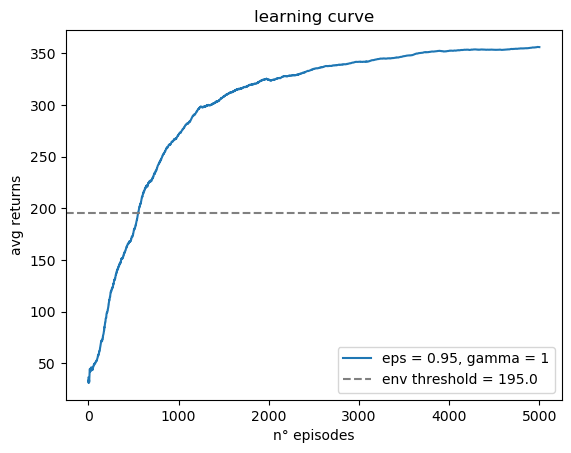

In [60]:
'''
initialization and run of the algorithm; here it is important to approapriately set the epsilon and gamma parameter 
so as to obtain the best efficiency, namely learn the optimal policy in the fastest way
'''
MC_agent = MC_learning(intervals = intervals, n_split = n_split, env = env, epsilon=.95, gamma=1, alpha = 0.99)
MC_agent.run()
x = np.arange(len(MC_agent.timestamps))
accumul = 0
mobile_avg = []
counter = 0
for elem in MC_agent.timestamps: 
    counter += 1
    accumul = accumul + (1/counter)*(elem-accumul) 
    mobile_avg.append(accumul)
    
plt.plot(x,mobile_avg, label='eps = 0.95, gamma = 1')  # replace accordingly with the parameters used in the algorithm
plt.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
plt.xlabel('n° episodes')
plt.ylabel('avg returns') 
plt.title('learning curve')
plt.legend()
plt.plot

In [ ]:
# '''
# cell used for plotting purpose 
# '''

# overall_timestamps = []

# for k in range(len(plot_timestamps)):
#     timestamps = plot_timestamps[k]
#     accumul = 0
#     mobile_avg = []
#     counter = 0
#     for elem in timestamps: 
#         counter += 1
#         accumul = accumul + (1/counter)*(elem-accumul) 
#         mobile_avg.append(accumul)
#     overall_timestamps.append(mobile_avg)

# x = np.arange(len(overall_timestamps[0]))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
# fig.suptitle('plot against epsilon and gamma parameter')
# ax1.set_title("variation with different epsilon")
# ax1.plot(x,overall_timestamps[0], label='eps = 0.95, gamma = 1')
# ax1.plot(x,overall_timestamps[1], label='eps = 0.90, gamma = 1')
# ax1.plot(x,overall_timestamps[2], label='eps = 0.85, gamma = 1')
# ax1.plot(x,overall_timestamps[3], label='eps = 0.80, gamma = 1')
# ax1.plot(x,overall_timestamps[4], label='eps = 0.75, gamma = 1')
# ax1.plot(x,overall_timestamps[10], label='eps = 1.00, gamma = 1')
# ax1.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
# ax1.legend()

# ax2.set_title("variation with different gamma")
# ax2.plot(x,overall_timestamps[5], label='eps = 0.90, gamma = 0.95')
# ax2.plot(x,overall_timestamps[6], label='eps = 0.90, gamma = 0.90')
# ax2.plot(x,overall_timestamps[7], label='eps = 0.90, gamma = 0.85')
# ax2.plot(x,overall_timestamps[8], label='eps = 0.90, gamma = 0.80')
# ax2.plot(x,overall_timestamps[9], label='eps = 0.90, gamma = 0.75')
# ax2.plot(x,overall_timestamps[11], label='eps = 0.90, gamma = 1')
# ax2.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
# ax2.legend()



In [ ]:
'''
In this cell, using the correct render option, it is possible to visualize thorugh real-time simulation the
final result associated to the policy learnt by the agent
'''
#env = gym.make(env_name, render_mode='rgb_array')   # for simulation
env = gym.make(env_name, render_mode='human')       # for rendering

# let's experience with the environment  
observation, info = env.reset()
curr_state = state_projection(observation, MC_agent.intervals)
for _ in range(10000):
   
   action = MC_agent.action_choice(curr_state) 
   new_state, reward, terminated, truncated, info = env.step(action)
   curr_state = state_projection(new_state, MC_agent.intervals)

   if terminated or truncated:
      observation, info = env.reset() 

In [ ]:
print(MC_agent.timestamps)

In [61]:
'''
Let's resolve the same environment exploiting the SARSA algorithm, based on the TD(0) idea
'''

class SARSA_learning():
    
    def __init__(self, intervals, n_split, env, epsilon = 0.98, alpha = 0.8, gamma = 1):  # in this case, we will use alpha as constant parameter for the update
                                                                                          # not alpha = 1/n as it is in the case of the MC implementation
        self.intervals = intervals
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.timestamps = []
        Q_height = 2 # since there are only two possible action 
        Q_width = (n_split[0]+2)*(n_split[1]+2)*(n_split[2]+2)*(n_split[3]+2)
        self.Q_table = np.zeros((2, Q_width))
        self.Counter_table = np.zeros_like(self.Q_table)
    
    def action_choice(self, curr_state):
        
        rand_value = np.random.randint(0, 100+1)/100 
        if(rand_value > self.epsilon):
            curr_action = int(np.random.choice([0, 1], size=1, p=[.5, .5]))
        else:
            curr_action = np.argmax(self.Q_table[:, curr_state]) 
        return curr_action  
    
    def step(self, curr_action):
        
        
        return new_state, reward, terminated, truncated
    
    def Q_table_update(self, curr_action, curr_state, new_state, new_action, reward):
        self.Counter_table[curr_action][curr_state] += 1
        self.Q_table[curr_action][curr_state] = self.Q_table[curr_action][curr_state] + \
                                                (1/self.Counter_table[curr_action][curr_state])*(reward + self.gamma*self.Q_table[new_action][new_state]-self.Q_table[curr_action][curr_state])
                                                #self.alpha*(reward + self.gamma*self.Q_table[new_action][new_state]-self.Q_table[curr_action][curr_state])
                                           
        return 
        
    def run(self, n_episodes = 5000):
        
        for _ in tqdm(range(n_episodes)):
            curr_state, info = self.env.reset()
            curr_state = state_projection(curr_state, self.intervals)
            curr_action = self.action_choice(curr_state)    
            index = 0
            while(True):
                index +=1
                new_state, reward, terminated, truncated, info = self.env.step(curr_action)
                if terminated or truncated:
                    #print("episode last for {} timestemps".format(index))
                    self.timestamps.append(index)
                    break
                new_state = state_projection(new_state, self.intervals)
                new_action = self.action_choice(new_state)
                self.Q_table_update(curr_action, curr_state, new_state, new_action, reward)
                curr_state = new_state
                curr_action = new_action

100%|██████████| 5000/5000 [00:19<00:00, 252.23it/s]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

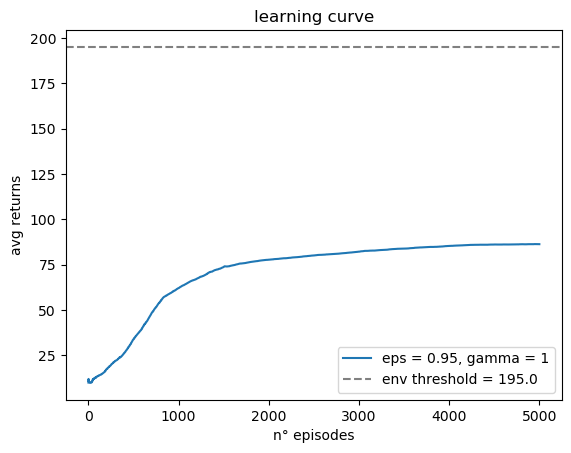

In [62]:
env = gym.make(env_name, render_mode='rgb_array')   # for simulation 
SARSA_agent = SARSA_learning(intervals = intervals, n_split = n_split, env = env, epsilon=.95, alpha = 0.8, gamma=1)
SARSA_agent.run()

x = np.arange(len(SARSA_agent.timestamps))
accumul = 0
mobile_avg = []
counter = 0
for elem in SARSA_agent.timestamps: 
    counter += 1
    accumul = accumul + (1/counter)*(elem-accumul) 
    mobile_avg.append(accumul)
    
plt.plot(x,mobile_avg, label='eps = 0.95, gamma = 1')  # replace accordingly with the parameters used in the algorithm
plt.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
plt.xlabel('n° episodes')
plt.ylabel('avg returns') 
plt.title('learning curve')
plt.legend()
plt.plot

In [ ]:
print(SARSA_agent.timestamps)

In [ ]:
env = gym.make(env_name, render_mode='human')       # for rendering

# let's experience with the environment  
observation, info = env.reset()
curr_state = state_projection(observation, SARSA_agent.intervals)
for _ in range(10000):
   
   action = SARSA_agent.action_choice(curr_state) 
   new_state, reward, terminated, truncated, info = env.step(action)
   curr_state = state_projection(new_state, SARSA_agent.intervals)

   if terminated or truncated:
      observation, info = env.reset() 